In [1]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from random import shuffle
from scipy.stats import ranksums
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [2]:
#import cv2 as cv

In [3]:
# Definición de variables 
acc = []
acc_sh = []
cm = np.zeros((2,2))
cm_sh = np.zeros((2,2))
features_selected = np.zeros(100)
features_selected_sh = np.zeros(100)

numfeat = 2 # numero de features para usar con feature selection univariado 

## NO MODIFICAR
# Este codigo existe para seleccionar un threshold que haga a las matrices de confusion lo mas diagonales posibles NA
def diag_cm(classifier, X_test_new): 
    thr = np.arange(0,1,0.1)
    opt = 10*len(X_test_new)
    for t in thr:
        pred = classifier.predict_proba(X_test_new)[:,1]>t
        cm_temp = np.double(np.array(confusion_matrix(y,pred)))
        opt_temp = np.abs(cm_temp[0,0] - cm_temp[1,1])+cm_temp[0,1]+cm_temp[1,0]
        if opt_temp<opt:
            cm_out = cm_temp
            opt=opt_temp
           # print(opt)
           # print(cm_out)
    return cm_out

In [4]:
# 1) Cargar matriz de features (modificar los path)


data_CN = np.load('ictal.npy')
data_EP = np.load('Interictal.npy')
#data_CN = np.array(pd.read_csv('ictal.npy',delimiter=' ',header=None))
#data_EP = np.array(pd.read_csv('Interictal.npy',delimiter=' ',header=None))

In [5]:
# 2) Crear la matriz con clases (ceros y unos)

#Etiquetado 
y_CN = np.zeros(data_CN.shape[0])
y_EP = np.ones(data_EP.shape[0])

#Union de matriz X y Vector Y
y = np.concatenate((y_CN,y_EP))
X = np.concatenate((data_CN,data_EP))

# X datos matriz de features
# y vector de etiquetas

In [14]:
X.shape

(100, 12)

In [7]:
# 3) Generar esquemas de partición
folds = 5 # folds de la validacion cruzada
iterations = 100 # itereaciones con para estimar el p-value con random shuffling de las etiquetas

## ESTO SI
# defino el clasificador (es un Gradient Boosting Classifier, similar a Random Forest)
classifier = GradientBoostingClassifier(n_estimators=1000,learning_rate= 0.01, max_features= 2)

all_tprs = []
all_aucs = []

mean_fpr = np.linspace(0, 1, 1000) # esto sirve para plotear el ROC 

In [8]:
#selector = SelectKBest(k=numfeat).fit(X, y)
#X_new = selector.transform(X)
#X_test_new = selector.transform(X)

In [9]:
#classifier.fit(X_new, y)

In [15]:


# 4) Para cada partición (entrenar, testear)
#for (train, test) in enumerate(cv.split(X, y)):
selector = SelectKBest(k=numfeat).fit(X, y) # selecciona con F-score los mejores features
X_new = selector.transform(X)
X_test_new = selector.transform(X)
        
        ###
      #print(selector.get_support())  
      #features_selected[selector.get_support()]=features_selected[selector.get_support()]+1   
#features = X.feature_names
#features_selected_example = features[selector.get_support()]     
classifier.fit(X, y) # clasificador ACA SE ENTRENA
acc.append(sklearn.metrics.accuracy_score(y,classifier.predict(X) )) # testting classifier ACA SE TESTEA
cm_temp = diag_cm(classifier,X) # MATRIZ DE CONFUSION
cm_temp[0,:]= cm_temp[0,:]/np.sum(cm_temp[0,:])
cm_temp[1,:]= cm_temp[1,:]/np.sum(cm_temp[1,:])
cm = cm + cm_temp
        

    


In [11]:
X_new

array([[  0.5484786 ,  53.        ],
       [  0.44410872,  54.        ],
       [  0.46181925,  40.        ],
       [  0.37578264,  46.        ],
       [  0.45876277,  49.        ],
       [  0.36436053,  34.        ],
       [  0.37027796,  37.        ],
       [  0.40298696,  38.        ],
       [  0.39091344,  34.        ],
       [  0.45409003,  55.        ],
       [  0.41590802,  44.        ],
       [  0.59841992,  69.        ],
       [  0.17331882, 117.        ],
       [  0.53985626,  56.        ],
       [  0.52792693,  61.        ],
       [  0.48630152,  53.        ],
       [  0.43956051,  49.        ],
       [  0.43532537,  52.        ],
       [  0.48719231,  54.        ],
       [  0.48314852,  56.        ],
       [  0.4786079 ,  75.        ],
       [  0.50667988,  57.        ],
       [  0.43986753,  58.        ],
       [  0.50553087,  49.        ],
       [  0.38617025,  64.        ],
       [  0.38288518,  73.        ],
       [  0.45162316,  52.        ],
 

C:\Users\moysm\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


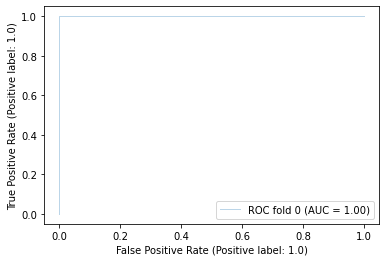

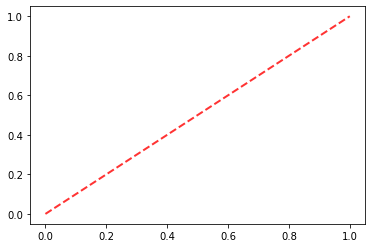

In [17]:
tprs = []
aucs = []
viz = plot_roc_curve(classifier, X, y,
                            name='ROC fold {}'.format(0),
                            alpha=0.3, lw=1) # esto es una forma complicada de obtener el AUC
interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)
aucs.append(viz.roc_auc) # sacando area bajo la curva
fig, ax = plt.subplots() 
  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
    